In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os
import torch
from model.decoder.vit_pixel_decoder import VitPixelDecoder
from omegaconf import OmegaConf

from janus.models import MultiModalityCausalLM
from util.dataloader import get_dataloader

exp_dir = "/data1/jjc/experiment/decoder/0612_decoder"
# config = OmegaConf.load("config/vit_pixel_decoder.yaml")
config = OmegaConf.load(os.path.join(exp_dir, "config.yaml"))

dataloader = get_dataloader(config.data)
janus = MultiModalityCausalLM.from_pretrained(config.janus_path, trust_remote_code=True)
extractor = janus.vision_model

decoder = VitPixelDecoder(config.decoder)
ckpt = torch.load(os.path.join(exp_dir, "Decoder-decoder-120k"), map_location="cpu")
decoder.load_state_dict(ckpt, strict=True)
decoder.eval();

/data1/jjc/cache/tmp/ipykernel_1987935/3396631647.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(exp_dir, "Decoder-decoder-120k"), map_l

torch.Size([1, 576, 1024])
torch.Size([1, 3, 384, 384])


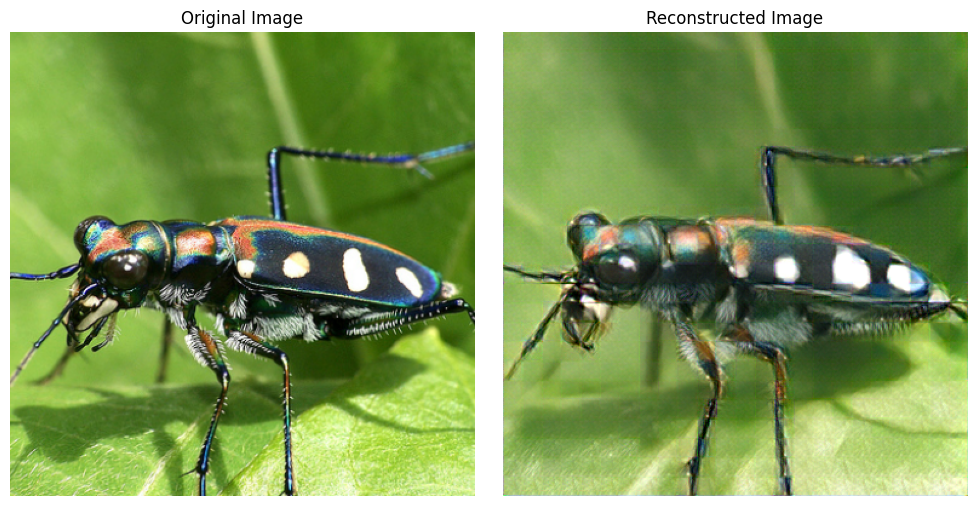

In [33]:
import torchvision.transforms as pth_transforms
# --------- 加载数据 ---------
batch = next(iter(dataloader))
x, y = batch
# --------- 重建 ---------
with torch.no_grad():
    ori = x[0].unsqueeze(0)
    ori = ori * 2 - 1
    feature = extractor(ori)
    print(feature.shape)
    rec = decoder(feature)
    print(rec.shape)

# --------- 绘图 ---------
inversed_transform = pth_transforms.Compose([
    pth_transforms.ToPILImage(),
])

rec_img = ((rec + 1) / 2).clamp(0, 1)
rec_img = inversed_transform(rec_img.squeeze(0))

ori_img = ((ori + 1) / 2).clamp(0, 1)
ori_img = inversed_transform(ori_img.squeeze(0))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ori_img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rec_img)
plt.title('Reconstructed Image')
plt.axis('off')

plt.tight_layout()
plt.show()
